# Fast Minimum Norm (FMN) Attack (with robust models)

In [1]:
import os
import sys

In [2]:
paths = ['..']
for path in paths:
    if os.path.abspath(path) not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
        print(os.path.abspath(path))

/nfs/data/andrewbai/Fast-Minimum-Norm-FMN-Attack


In [3]:
import logging

import numpy as np
import torch
from foolbox import TargetedMisclassification, Misclassification
from foolbox.zoo import zoo
from importlib import reload

from src.attacks import fmn
reload(fmn)

from src.attacks.fmn import L0FMNAttack, L1FMNAttack, \
    L2FMNAttack, LInfFMNAttack
from src.models.models import models
from src.utils.data import create_loaders
from src.utils.show_digit import show_image

After the initial imports, we now take care of some setup.

In [4]:
%%capture
logger = logging.getLogger('progress')
logger.setLevel(logging.INFO)

data_dir = '../data'
norms = {'L0': 0, 'L1': 1, 'L2': 2, 'Linf': np.inf}
attacks = {'L0': L0FMNAttack, 'L1': L1FMNAttack,
           'L2': L2FMNAttack, 'Linf': LInfFMNAttack}

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

Now we can load a **model**. We have the following models from the zoo:
* 0 - MnistClean
* 1 - MnistChallenge
* 2 - RonyMnist
* 3 - CarmonUnlabeled
* 4 - RonyCifar
* 5 - CifarChallenge

Just setting the index will be sufficient to download and prepare the model.

In [5]:
%%capture
model_idx = 5

m = models[model_idx]
model_name, model_url, module_name, task, transform, model_kwargs = m
num_classes = {'MNIST': 10, 'CIFAR10': 10}[task]

# load model
fb_model = zoo.get_model(model_url,
                         module_name=module_name, overwrite=True, **model_kwargs)

We now prepare the dataset to be used, according to the model.

In [6]:
num_batches = 1
batch_size = 20
n_workers = 1
data_loader = create_loaders(data_dir, task_config=task,
                             batch_size=batch_size,
                             transform=transform,
                             random_state=0,
                             n_workers=n_workers)

Files already downloaded and verified


We can compute the accuracy of the model, just to confirm that it is working
properly.

In [7]:
# compute clean accuracy
total, correct = 0.0, 0.0
for b, (inputs, labels) in enumerate(data_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    pred = fb_model(inputs).argmax(1)
    total += labels.shape[0]
    correct += (pred == labels).sum()
    if total >= 1000:
        break
print("Model name: {}".format(model_name))
print("Clean accuracy: {:.4f}".format(correct / total))


Model name: Cifar10Challenge
Clean accuracy: 0.8730


And finally, we can define the attack. We are now running the attack
with the simplest configuration. Set the `targeted` parameter to `True` or
`False` to run respectively a targeted or an untargeted attack. The targeted
version will automatically select the target labels.

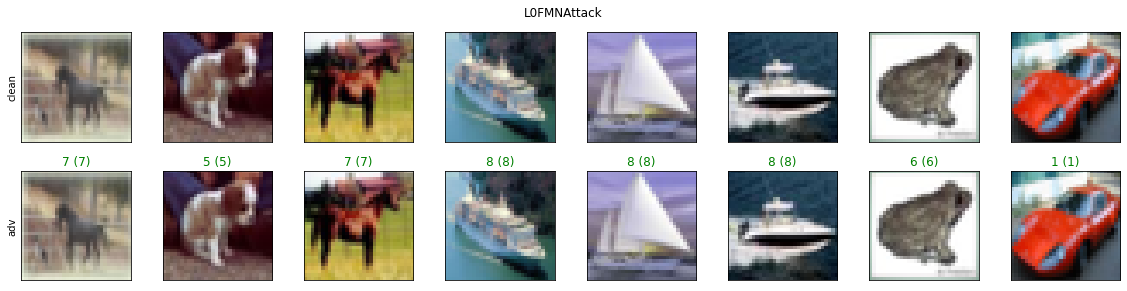

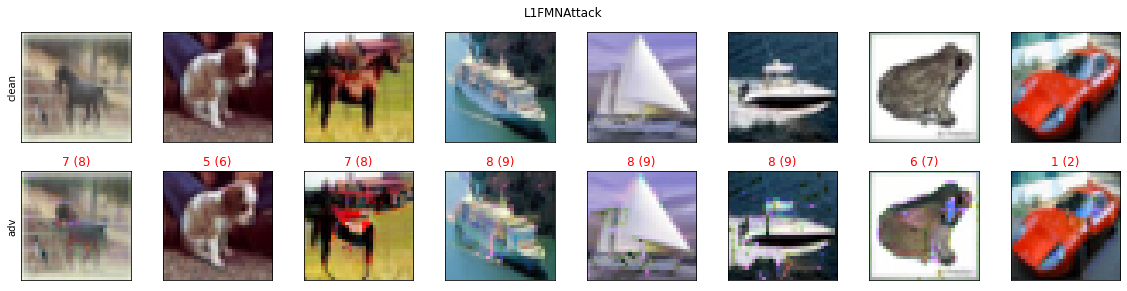

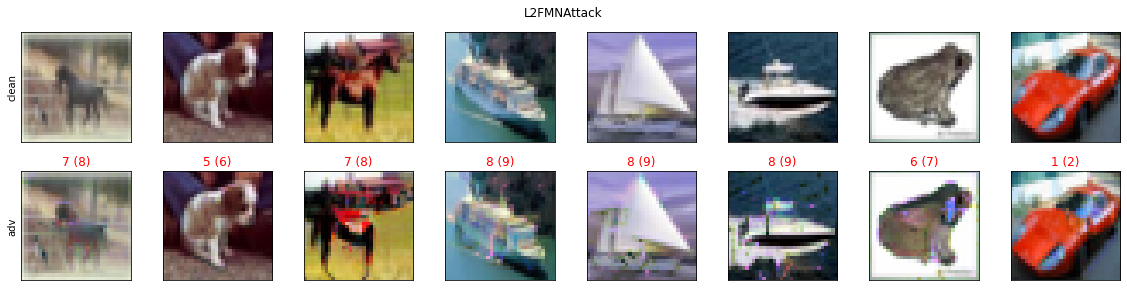

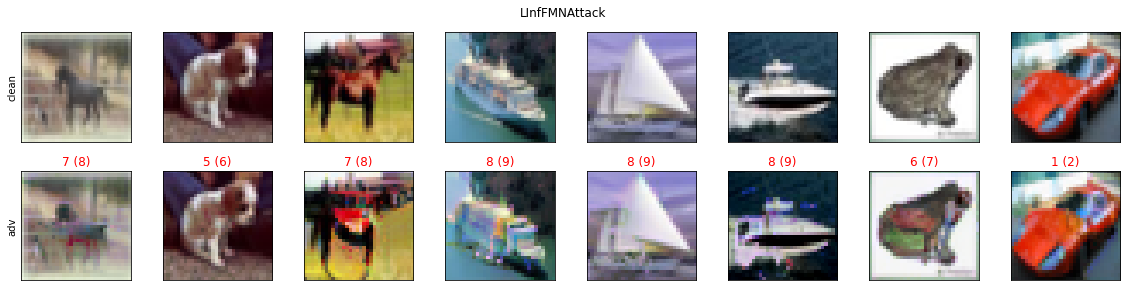

In [8]:
targeted = True
logger.info(f"attack target: {targeted}")
steps = 100
init_params = dict(steps=steps,
                   max_stepsize=1.0,
                   gamma=0.05)

img_shape = {'MNIST': (28, 28), 'CIFAR10': (3, 32, 32)}[task]
for metric in norms:

    attack_class = attacks[metric]
    attack = attack_class(**init_params)

    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)


    if targeted:
        target_classes = (labels + 1) % 10
        criterion = TargetedMisclassification(target_classes)
    else:
        criterion = Misclassification(labels)
    advs, _, is_adv = attack(fb_model, images, criterion, epsilons=None)

    diffs = advs - images
    preds = fb_model(advs).argmax(-1)
    title = attack.__class__.__name__
    show_image(title, images, advs, preds, labels, n_display=8,
               img_shape=img_shape)
